In [4]:
# imports go here
import numpy as np
import db
import pandas as pd
import inflect
import string
import nltk
import gensim
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim import corpora, models
from nltk.test.gensim_fixt import setup_module
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

# this is where everything we've experimented on will be implemented.


class AnomalyDetector():
    def __init__(self, dbName: str = "",  dh=None, model=None, modelName="glove-wiki-gigaword-300") -> None:
        if dh is None:
            self.dh = db.DatabaseHandler(dbName=dbName)
        else:
            self.dh = dh
        if model is None:
            if modelName != "":
                self.model = api.load(modelName)
        else:
            self.model = model

        self.FeatureExtractionParams = {}
        self.AnomalyDetectionParams = {}

    '''
    inputs :
    - dh : DatabaseHandler --> to retrieve data from database
    - eventID : int --> we're doing this by event, so straight to the eventID
    - selector : str --> pretty much formality.
    - splitBySentences : bool --> Split each doc into sentences or not. Defaults to no.
    '''
    '''
    outputs:
    None, just setting
    '''

    def SetDFFromDB(self, eventID: int, selector: str = "event_id", splitBySentences: bool = False):
        self.df = self.dh.get_recordDataJoinedDF(selector=selector, ID=eventID)
        if splitBySentences:
            # df.set_index('id', inplace=True)
            self.df['answer'] = self.df['answer'].str.split('.')
            self.df = self.df.explode("answer", True)
            self.df.drop(self.df[self.df["answer"] == ""].index, inplace=True)
            self.df.reset_index(drop=True, inplace=True)

    # ditto above, but takes a pre-made DF instead.
    def SetDF(self, df: db.pd.DataFrame, splitBySentences: bool = False):
        self.df = df
        if splitBySentences:
            # df.set_index('id', inplace=True)
            self.df['answer'] = self.df['answer'].str.split('.')
            self.df = self.df.explode("answer", True)
            self.df.drop(self.df[self.df["answer"] == ""].index, inplace=True)
            self.df.reset_index(drop=True, inplace=True)

    def SetModel(self, modelName: str = "glove-wiki-gigaword-300"):
        self.model = api.load(modelName)

    # these are to add key:value to the dictionaries that dictate parameters. Indeed, we are refurbishing.
    def SetFeatureExtractionParam(self, key: str, value):
        self.FeatureExtractionParams[key] = value

    def SetAnomalyDetectionParam(self, key: str, value):
        self.AnomalyDetectionParams[key] = value

    '''
    inputs :
    - dh : DatabaseHandler --> to retrieve data from database
    - eventID : int --> we're doing this by event, so straight to the eventID
    - selector : str --> pretty much formality.
    - splitBySentences : bool --> Split each doc into sentences or not. Defaults to no.
    '''
    '''
    outputs:
    - df : DataFrame --> dataframe containing the thing we're gonna be using.
    '''

    def GetDF(self, dh: db.DatabaseHandler, eventID: int, selector: str = "event_id", splitBySentences: bool = False):
        df = dh.get_recordDataJoinedDF(selector=selector, ID=eventID)
        if splitBySentences:
            # df.set_index('id', inplace=True)
            df['answer'] = df['answer'].str.split('.')
            df = df.explode("answer", True)
            df.drop(df[df["answer"] == ""].index, inplace=True)
            df.reset_index(drop=True, inplace=True)
        return df

    '''
    inputs:
    - doc : str --> a string representing a sentence/document.
    - isLemma : bool --> use lemmatizer or not? Defaults to not.
    - isStopWords : bool --> use stopwords or not? Defaults to not.
    - isInflect : bool --> use inflections (you're --> you are) or not? Defaults to not.
    - isNumberFiltered :  bool --> delete numbers in the string? Defaults to yes. 
    '''
    '''
    output : list<str> --> a list of word tokens (list<string>)
    '''

    def PreprocessDocument(self, doc: str, isLemma: bool = False, isStopWords: bool = False, isInflect: bool = False, isNumberFiltered: bool = True):
        inflector = inflect.engine()
        stopwordSet = set(stopwords.words("english"))
        lemmatizer = WordNetLemmatizer()
        punctuations = string.punctuation
        # if numbers are filtered, add that to the punctuation string
        if isNumberFiltered:
            punctuations += "1234567890"

        # case fold
        doc = doc.lower()

        # remove puncs
        doc = "".join([char for char in doc if char not in punctuations])

        # tokenize it.
        token_list = nltk.word_tokenize(doc)

        for i in range(len(token_list)):
            # if inflect
            if isInflect:
                if token_list[i].isdigit():
                    token_list[i] = inflector.number_to_words(token_list[i])

            # if lemma
            if isLemma:
                tagged_word = nltk.pos_tag([token_list[i]])
                wordnet_pos = self.getWordnetPos(tagged_word[0][1])
                token_list[i] = lemmatizer.lemmatize(
                    tagged_word[0][0], pos=wordnet_pos)

            # if stopword
            if isStopWords:
                if token_list[i] in stopwordSet or token_list[i].isdigit():
                    token_list[i] = "#"  # mark as #

        # remove the marked strings
        token_list = [token for token in token_list if token != "#"]

        if token_list:
            return token_list
        return [""]

    '''
    inputs:
    - tag : str --> the tag obtained from POS tagging.
    '''
    '''
    outputs:
    - str --> Wordnet POS tag.
    '''

    def getWordnetPos(self, tag):
        """Map POS tag to WordNet POS tag"""
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # solves as noun by default.

    '''
    inputs:
    - doclist : list<str> --> list of doc/sentences.
    - isProcessed : bool --> has it already been preprocessed? Defaults to True.
    '''
    '''
    outputs:
    - df_tfidf : Dataframe --> the TFIDF matrix in df form. 
    - matrix : matrix --> the TFIDF matrix purely. mainly for LDA purposes.
    '''

    def GetTFIDF(self, doclist: list, isPreprocessed=True):
        if not isPreprocessed:
            doclist = [self.PreprocessDocument(
                doc, isLemma=True, isStopWords=True) for doc in doclist]
        # else:
        #     # just tokenize the thing
        #     doclist = [nltk.word_tokenize(doc) for doc in doclist]
        # i think the thing has already been tokenized. That's the problem.
        flat_doclist = [' '.join(doc)
                        for doc in doclist]  # turn into one big corpus
        vectorizer = TfidfVectorizer()
        matrix = vectorizer.fit_transform(flat_doclist)
        tfidf_keys = vectorizer.get_feature_names_out()
        df_tfidf = db.pd.DataFrame(matrix.toarray(), columns=tfidf_keys)

        return df_tfidf, matrix

    # input : list<str> : tokens of one document/sentence
    # output : list<(str, list<int>[300])> : list of word-vector pair for each word available on the model
    def WordEmbed(self, document: list, model):
        word_embed_pairs = []
        for word in document:
            if word in model:
                word_embed_pairs.append((word, model[word]))
        return word_embed_pairs

    '''
    inputs :
    - model         :           -->word2vec model
    - document      : list<str> --> a list of word tokens to embed.
    - maxLength     : int       --> the maximum length, to pad the vector with if necessary.
    - weighted      : bool      --> multiply each word with respective TF-IDF score or not.
    '''

    def TinyWordEmbed(self, document: list, model, maxLength: int):
        features = []
        # this creates a feature length of len(document)
        for word in document:
            if word in model:
                features.append(np.mean(model[word], axis=0))
        # if less than maxLength, pad with zeros.
        if len(features) < maxLength:
            padLength = maxLength - len(features)
            padding = np.zeros(padLength)
            features = np.concatenate((features, padding))

        # i remain pessimistic that this would work.
        return features

    # ditto TinyWordEmbed but with weight
    def TinyWordEmbedWeighted(self, document: list, model, maxLength: int, index: int):
        features = []
        for word in document:
            if word in model:
                weight = 0
                if word in self.tfidf_df:
                    weight = self.tfidf_df[word][index]
                features.append(
                    np.mean(model[word], axis=0) * weight)
                
        # if less than maxLength, pad with zeros.
        if len(features) < maxLength:
            padLength = maxLength - len(features)
            padding = np.zeros(padLength)
            features = np.concatenate((features, padding))

        # i remain pessimistic that this would work.
        return features

    # input : list<(str, list<float>[300])>, str : word-vector pair list and preferred agg method.
    # output : list<float>[300] : 300-d vector that represents an aggregated value of the input words

    def SentenceEmbedUnweightedFunction(self, word_embed_pair_list: list, aggregateMethod: str = "avg"):
        wvs = []
        for pair in word_embed_pair_list:
            wvs.append(pair[1])
        if aggregateMethod == "avg":
            return np.mean(wvs, axis=0)
        else:
            return np.sum(wvs, axis=0)

    # input : list<list<(str, list<float>[300])>>, str : list containing word-vector pairs and preferred agg method
    # output : list<(str, list<int>[300])> : list containing sentence-vector pairs.
    def SentenceEmbedUnweighted(self, word_embedded_docs: list, aggregateMethod: str = "avg"):
        sentence_embedded_docs = []
        for i in range(len(word_embedded_docs)):
            sentence_embedded_docs.append(self.SentenceEmbedUnweightedFunction(
                word_embedded_docs[i], aggregateMethod))
        return sentence_embedded_docs

    '''
    input :
    list<list<(str, list<float>[300])>> : word-vector pair list
    matrix : tf-idf matrix for the corresponding doc
    int : the row we want
    str : preferred agg method
    '''
    # output : list<float>[300] : 300-d vector that represents an aggregated value of the input words

    def SentenceEmbedWeightedFunction(self, word_embed_pair_list: list, tfidf_matrix, index: int, aggregateMethod: str = "avg"):
        weighted_wvs = []
        # multiplies each word with its TF-IDF value in the corresponding row. Is 0 if word isn't found somehow.
        for pair in word_embed_pair_list:
            tfidf_weight = 0
            if pair[0] in tfidf_matrix:
                tfidf_weight = tfidf_matrix[pair[0]][index]
            weighted_wvs.append(pair[1] * tfidf_weight)
        # turn into array for fast aggregating
        weighted_wvs = np.array(weighted_wvs)
        if aggregateMethod == "avg":
            sentence_vector = np.mean(weighted_wvs, axis=0)
        else:
            sentence_vector = np.sum(weighted_wvs, axis=0)
        return sentence_vector

    # input : list<list<(str, list<float>[300])>>, str : list containing word-vector pairs, TF-IDF matrix of the corpus, and preferred agg method
    # output : list<(str, list<float>[300])> : list containing sentence-vector pairs.
    def SentenceEmbedWeighted(self, word_embedded_docs: list, tfidf_matrix, aggregateMethod="avg"):
        sentence_embedded_docs = []
        for i in range(len(word_embedded_docs)):
            sentence_embedded_docs.append(self.SentenceEmbedWeightedFunction(
                word_embedded_docs[i], tfidf_matrix, i, aggregateMethod))
        return sentence_embedded_docs

    '''
    input:
    - doclist : list<list<str>> --> list of tokenized sentences/docs
    - topics : int --> number of inferred topics.
    - use_tfidf : bool --> use TFIDF or not? defaults to yes.
    '''
    '''
    output:
    - docFeatureList : list<list<float>> --> topic distribution for each sentence/doc
    '''

    def GetLDADistribution(self, doclist: list, topics: int = 5, use_tfidf: bool = True):
        new_corpus = []

        if use_tfidf:
            for i in range(len(doclist)):
                doc = [(j, self.tfidf_matrix[i, j])
                       for j in self.tfidf_matrix[i].indices]
                new_corpus.append(doc)
                gensim_dict = corpora.Dictionary.from_corpus(new_corpus)
        else:
            gensim_dict = corpora.Dictionary(doclist)
            new_corpus = [gensim_dict.doc2bow(doc) for doc in doclist]

        lda_model = gensim.models.LdaModel(
            new_corpus, num_topics=topics, id2word=gensim_dict)
        goofy_ahh_doc_topic_distributions = lda_model[new_corpus]

        docFeatureList = []
        for doc_topic_dist in goofy_ahh_doc_topic_distributions:
            featureList = [0.0 for i in range(0, topics)]
            for topic_dist in doc_topic_dist:
                featureList[topic_dist[0]] = topic_dist[1]
            docFeatureList.append(featureList)

        return docFeatureList

    '''
    inputs:
    - vectors : list<list<float>> --> list of features corresponding to each doc/sentence
    - epsilon : float --> the radius within which points are considered connected.
    - min : int --> minimum amount of connected points for a point to be considered a core point of a cluster.
    '''
    '''
    output:
    clusters : list<int> --> a list of integers to assign each data point to a cluster. -1 means outlier.
    '''

    def GetDBSCANClusters(self, vectors, epsilon: float, min: int):
        dbscan = DBSCAN(eps=epsilon, min_samples=min)
        clusters = dbscan.fit_predict(vectors)
        # plt.title("to the depths of depravity {} and the cusp of blasphemy {}.".format(epsilon, min))
        # plt.scatter(vectors[:, 0], vectors[:, 1], c=clusters)
        # plt.show()
        # print(clusters)
        return clusters
    '''
    inputs:
    - vectors : list<list<float>> --> list of features corresponding to each doc/sentence

    '''

    def GetIFResults(self, vector):
        isolationForest = IsolationForest(n_estimators=500, contamination=0.1)
        isolationForest.fit(vector)
        IFResults = isolationForest.decision_function(vector)

        # minus values yield anomalies.
        for i in range(len(IFResults)):
            if IFResults[i] >= 0:
                IFResults[i] = 0
            else:
                IFResults[i] = -1
        return IFResults

    '''
    inputs :
    - clusters : list<int> --> a list of clusters assigned to each doc/sentence
    - df : DataFrame --> the dataframe in question
    - isReturnSeparate : bool --> split return or not. Defaults to split (for some reason...)
    '''
    '''
    outputs:
    - dfOutliers : DataFrame --> the dataframe whose answers have been marked as outliers.
    - dfGoods : DataFrame --> the dataframe whose answers have not been marked as outliers.
    '''

    def ReturnClusters(self, isReturnSeparate: bool = True):
        if isReturnSeparate:
            dfGoods = self.df.loc[self.df["Cluster Assignment"] != -1]
            dfGoods.reset_index(inplace=True)
            dfOutliers = self.df.loc[self.df["Cluster Assignment"] == -1]
            dfOutliers.reset_index(inplace=True)
            return dfOutliers, dfGoods
        else:
            if self.df.isnull().values.any():
                self.df.reset_index(inplace=True)
            return self.df

    '''
    inputs:
    - method : str --> LDA or Embedding.
    - isWeighted : bool --> use weights or not
    - nTopics : int --> for LDA.
    '''
    '''
    - outputs : none. This is an internal function
    '''

    def GetAnomalies(self, isReturnSeparate: bool = False):
        self.SetDocumentTokens()  # set tokens in the DF
        if self.FeatureExtractionParams["method"] == "Embedding":
            self.SetEmbeddingResult()
        elif self.FeatureExtractionParams["method"] == "LDA":
            self.SetLDAResult()
        elif self.FeatureExtractionParams["method"] == "Tiny":
            self.SetTinyEmbeddingResult()

        if self.AnomalyDetectionParams["algorithm"] == "DBSCAN":
            self.SetDBSCANClusters(list(self.df["Document Embed"]))
        elif self.AnomalyDetectionParams["algorithm"] == "LOF":
            self.SetLOFClusters(list(self.df["Document Embed"]))
        elif self.AnomalyDetectionParams["algorithm"] == "IF":
            self.SetIFClusters(list(self.df["Document Embed"]))

        return self.ReturnClusters(isReturnSeparate=isReturnSeparate)

    '''
    inputs  : None (checks self.FeatureExtractionParams)
    desc    : embeds each doc and put it in a new column "Document Embed"
    '''

    def SetEmbeddingResult(self):
        # extract feature with embedding
        self.wordEmbeddedDocs = [self.WordEmbed(
            doc, self.model) for doc in self.preprocessedDocs]

        if "weighted" in self.FeatureExtractionParams and self.FeatureExtractionParams["weighted"]:
            self.tfidf_df, self.tfidf_matrix = self.GetTFIDF(
                self.preprocessedDocs)
            self.doc_embeds = self.SentenceEmbedWeighted(
                self.wordEmbeddedDocs, self.tfidf_df, self.FeatureExtractionParams["aggregate_method"])
        else:
            self.doc_embeds = self.SentenceEmbedUnweighted(
                self.wordEmbeddedDocs, self.FeatureExtractionParams["aggregate_method"])

        self.df["Document Embed"] = self.doc_embeds

    def SetTinyEmbeddingResult(self):
        # get max length
        maxdoc = max(self.preprocessedDocs, key=len)
        maxlen = len(maxdoc)
        # extract feature of each word with embedding
        self.doc_embeds = [self.TinyWordEmbed(
            doc, self.model, maxlen) for doc in self.preprocessedDocs]
        if "weighted" in self.FeatureExtractionParams and self.FeatureExtractionParams["weighted"]:
            self.tfidf_df, self.tfidf_matrix = self.GetTFIDF(self.preprocessedDocs)
            self.doc_embeds = [self.TinyWordEmbedWeighted(doc, self.model, maxlen, i) for i, doc in enumerate(self.preprocessedDocs)]
        self.df["Document Embed"] = self.doc_embeds

    def SetDefaultParams(self):
        # here we will put the default params
        self.SetFeatureExtractionParam("method", "Embedding")
        self.SetFeatureExtractionParam("weighted", True)
        self.SetFeatureExtractionParam("condense", False)
        self.SetFeatureExtractionParam("n_topics", 5)
        self.SetFeatureExtractionParam("aggregate_method", "avg")
        self.SetAnomalyDetectionParam("algorithm", "DBSCAN")
        self.SetAnomalyDetectionParam("epsilon", 1.0)
        self.SetAnomalyDetectionParam("minsamp", 2)
        self.SetAnomalyDetectionParam("epsilon", 1.0)
        self.SetAnomalyDetectionParam("algorithm", "IF")
        self.SetAnomalyDetectionParam("estimators", 500)
        self.SetAnomalyDetectionParam("contamination", 0.1)
        self.SetAnomalyDetectionParam("neighbors", 5)

    # preprocess each doc/sentence
    def SetDocumentTokens(self):
        self.preprocessedDocs = [self.PreprocessDocument(
            doc, isLemma=True, isStopWords=True) for doc in self.df["answer"]]
        self.df["Tokenized"] = self.preprocessedDocs

        # if cut off data with less than x values
        if "prune" in self.FeatureExtractionParams:
            mask = self.df['Embedded Docs'].apply(
                lambda x: len(x) > self.FeatureExtractionParams["prune"])
            self.df = self.df[mask]

    '''
    inputs  : None (checks self.FeatureExtractionParams)
    desc    : assigns topic distribution for each document.
    '''

    def SetLDAResult(self):
        doclist = list(self.df["Tokenized"])
        new_corpus = []
        if self.FeatureExtractionParams["weighted"]:
            self.tfidf_df, self.tfidf_matrix = self.GetTFIDF(
                self.preprocessedDocs)
            for i in range(len(doclist)):
                doc = [(j, self.tfidf_matrix[i, j])
                       for j in self.tfidf_matrix[i].indices]
                new_corpus.append(doc)
                gensim_dict = corpora.Dictionary.from_corpus(new_corpus)
        else:
            gensim_dict = corpora.Dictionary(doclist)
            new_corpus = [gensim_dict.doc2bow(doc) for doc in doclist]

        lda_model = gensim.models.LdaModel(
            new_corpus, num_topics=self.FeatureExtractionParams["n_topics"], id2word=gensim_dict)
        goofy_ahh_doc_topic_distributions = lda_model[new_corpus]

        docFeatureList = []
        for doc_topic_dist in goofy_ahh_doc_topic_distributions:
            featureList = [0.0 for i in range(
                0, self.FeatureExtractionParams["n_topics"])]
            for topic_dist in doc_topic_dist:
                featureList[topic_dist[0]] = topic_dist[1]
            docFeatureList.append(featureList)

        self.df["Document Embed"] = docFeatureList

    '''
    inputs  :
    - vectors : list<list<float>> --> list of features corresponding to each doc/sentence
    desc    : assigns cluster via DBSCAN. 
    '''

    def SetDBSCANClusters(self, vectors):
        dbscan = DBSCAN(
            eps=self.AnomalyDetectionParams["epsilon"], min_samples=self.AnomalyDetectionParams["minsamp"])
        clusters = dbscan.fit_predict(vectors)
        generalized_clusters = [0 if cluster != -1 else 1 for cluster in clusters]
        self.df["Cluster Assignment"] = generalized_clusters

    '''
    inputs:
    - vectors : list<list<float>> --> list of features corresponding to each doc/sentence

    '''

    def SetIFClusters(self, vector):
        isolationForest = IsolationForest(
            n_estimators=self.AnomalyDetectionParams["estimators"], contamination=self.AnomalyDetectionParams["contamination"])
        isolationForest.fit(vector)
        IFResults = isolationForest.decision_function(vector)

        # minus values yield anomalies.
        for i in range(len(IFResults)):
            if IFResults[i] >= 0:
                IFResults[i] = int(0)
            else:
                IFResults[i] = int(1)
        self.df["Cluster Assignment"] = IFResults

    '''
    inputs : vectors : list<list<float>> --> list of features for each doc/sentence
    '''

    def SetLOFClusters(self, vector):
        lof = LocalOutlierFactor(
            n_neighbors=self.AnomalyDetectionParams["neighbors"], contamination=self.AnomalyDetectionParams["contamination"])
        lof.fit(vector)
        LOFResults = lof.negative_outlier_factor_

        # minus values yield anomalies
        if "lof_generalize" in self.AnomalyDetectionParams and self.AnomalyDetectionParams["lof_generalize"]:
            print("if minus we go bald")
            LOFResults[LOFResults >= 0] = 0
            LOFResults[LOFResults < 0] = -1
        else:
            # if not generalize, we assume outliers are within the n-th percentile, with n = contamination rate.
            threshold = np.percentile(
                LOFResults, 100 * self.AnomalyDetectionParams["contamination"])
            LOFResults[LOFResults >= threshold] = 0
            LOFResults[LOFResults < threshold] = 1
        self.df["Cluster Assignment"] = LOFResults


In [5]:
dh = db.DatabaseHandler("testdb.db")
ad = AnomalyDetector(dh=dh, modelName="glove-wiki-gigaword-50")
ad.SetDefaultParams()
ad.SetDFFromDB(eventID=19, splitBySentences=False)
print(ad.AnomalyDetectionParams)
print(ad.FeatureExtractionParams)

{'algorithm': 'IF', 'epsilon': 1.0, 'minsamp': 2, 'estimators': 500, 'contamination': 0.1, 'neighbors': 5}
{'method': 'Embedding', 'weighted': True, 'condense': False, 'n_topics': 5, 'aggregate_method': 'avg'}


In [6]:
ad.SetDFFromDB(eventID=28, splitBySentences=False)
ad.SetFeatureExtractionParam("method", "LDA")
ad.SetFeatureExtractionParam("weighted", True)
ad.SetFeatureExtractionParam("n_topics", 10)

ad.SetAnomalyDetectionParam("algorithm", "IF")
ad.SetAnomalyDetectionParam("contamination", 0.2)
ad.SetAnomalyDetectionParam("estimators", 1000)
# ad.SetAnomalyDetectionParam("neighbors", 100)
# ad.SetAnomalyDetectionParam("epsilon", 0.25)
# ad.SetAnomalyDetectionParam("minsamp", 2)
ad.FeatureExtractionParams

{'method': 'LDA',
 'weighted': True,
 'condense': False,
 'n_topics': 10,
 'aggregate_method': 'avg'}

<h2> Jaccard distance babey

In [23]:
from sklearn.metrics import jaccard_score

def GetJaccardScore(ground, result):
    outliers = np.where((ground == 1) | (result == 1))
    ground_outliers = ground[outliers]
    result_outliers = result[outliers] 
    return jaccard_score(ground_outliers, result_outliers)

def GetVerdict(id, result):
    ground_labels = np.genfromtxt('hasilsurvey/{}.csv'.format(id), delimiter=',', skip_header=1, usecols=1)
    result_labels = result["Cluster Assignment"].to_numpy()
    return GetJaccardScore(ground_labels, result_labels)
    

<h2>Getting Set of Word Tokens

In [8]:
mySet = set()
eventIDList = [18, 19, 20, 27, 28]
for eventID in eventIDList:
    ad.SetDFFromDB(eventID=eventID, splitBySentences=False)
    result = ad.GetAnomalies()
    myList = ad.df["Tokenized"].tolist()
    for item in myList:
        for subItem in item:
            mySet.add(subItem)

print(len(mySet))


1048


<h4>Embedding each word-token.

In [47]:
def WordEmbed(collection, model):
    word_embed_pairs = []
    for word in collection:
        if word in model:
             word_embed_pairs.append((word, model[word]))
    return word_embed_pairs

C:\Users\peter\AppData\Local\Temp\ipykernel_22744\1228325159.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], cmap="viridis")


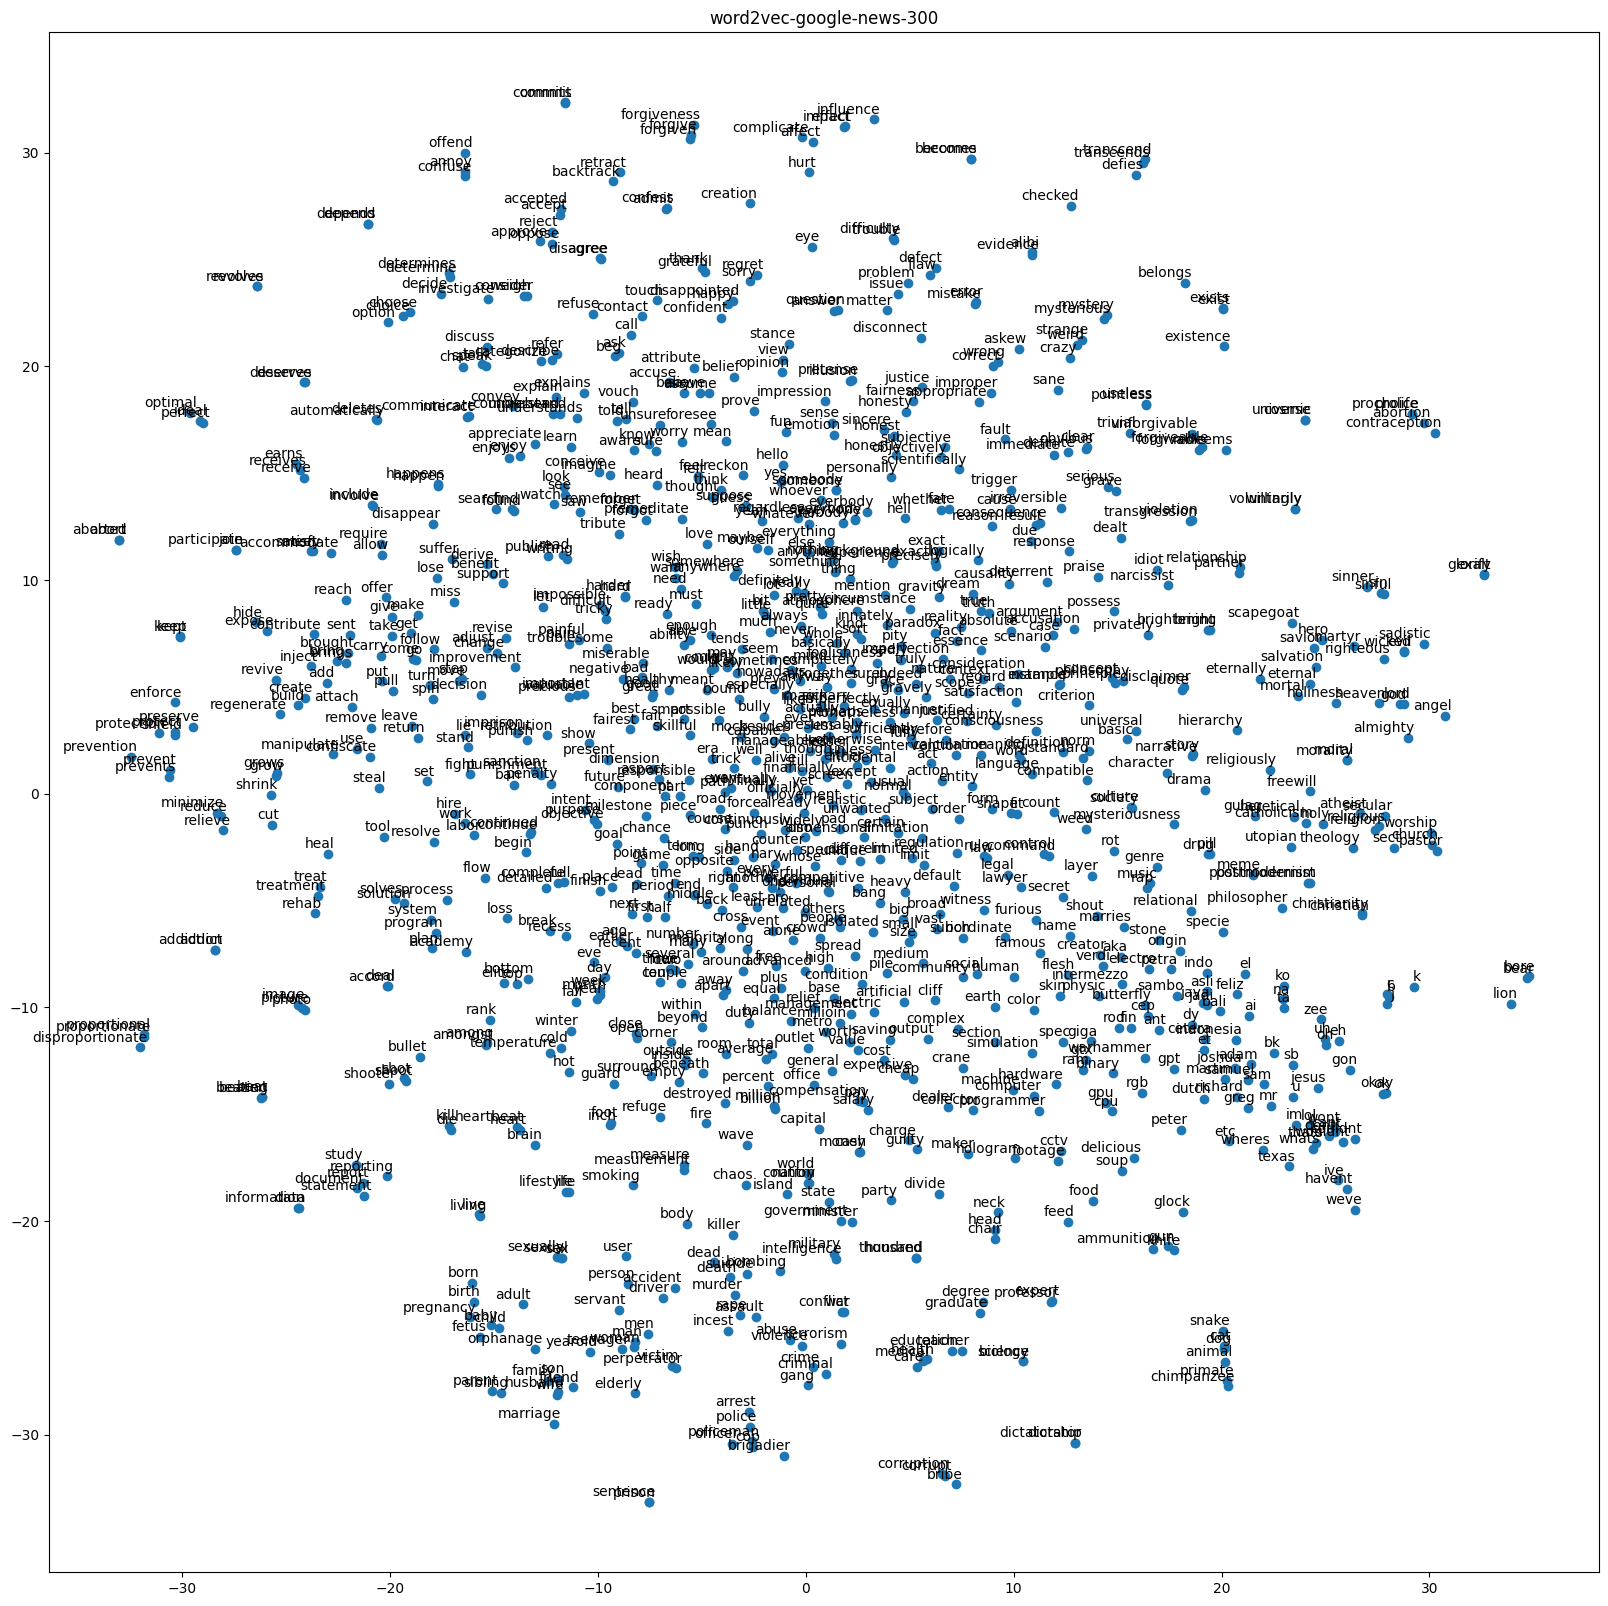

C:\Users\peter\AppData\Local\Temp\ipykernel_22744\1228325159.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], cmap="viridis")


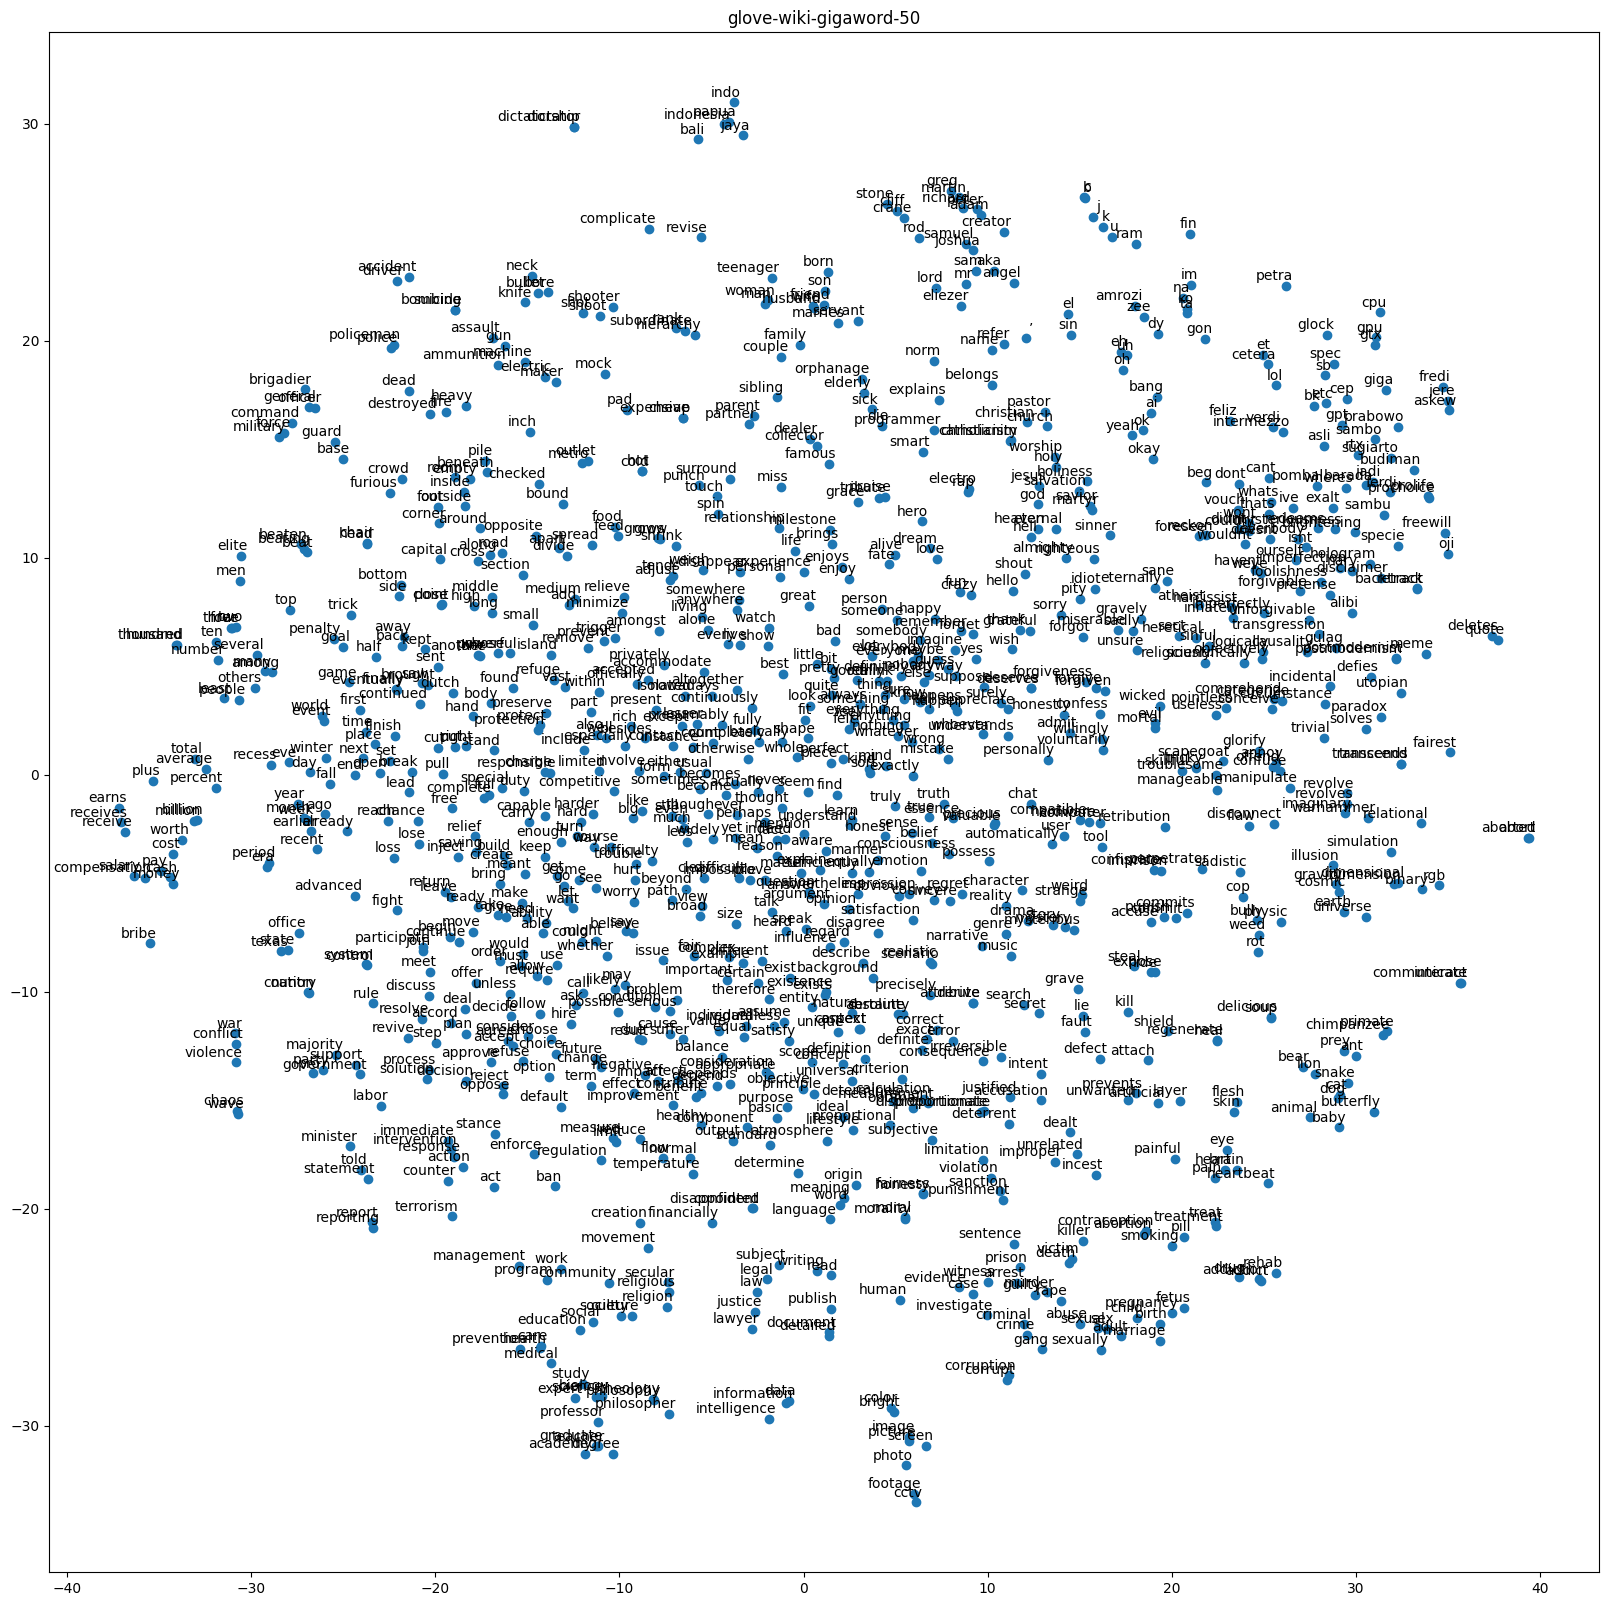

C:\Users\peter\AppData\Local\Temp\ipykernel_22744\1228325159.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], cmap="viridis")


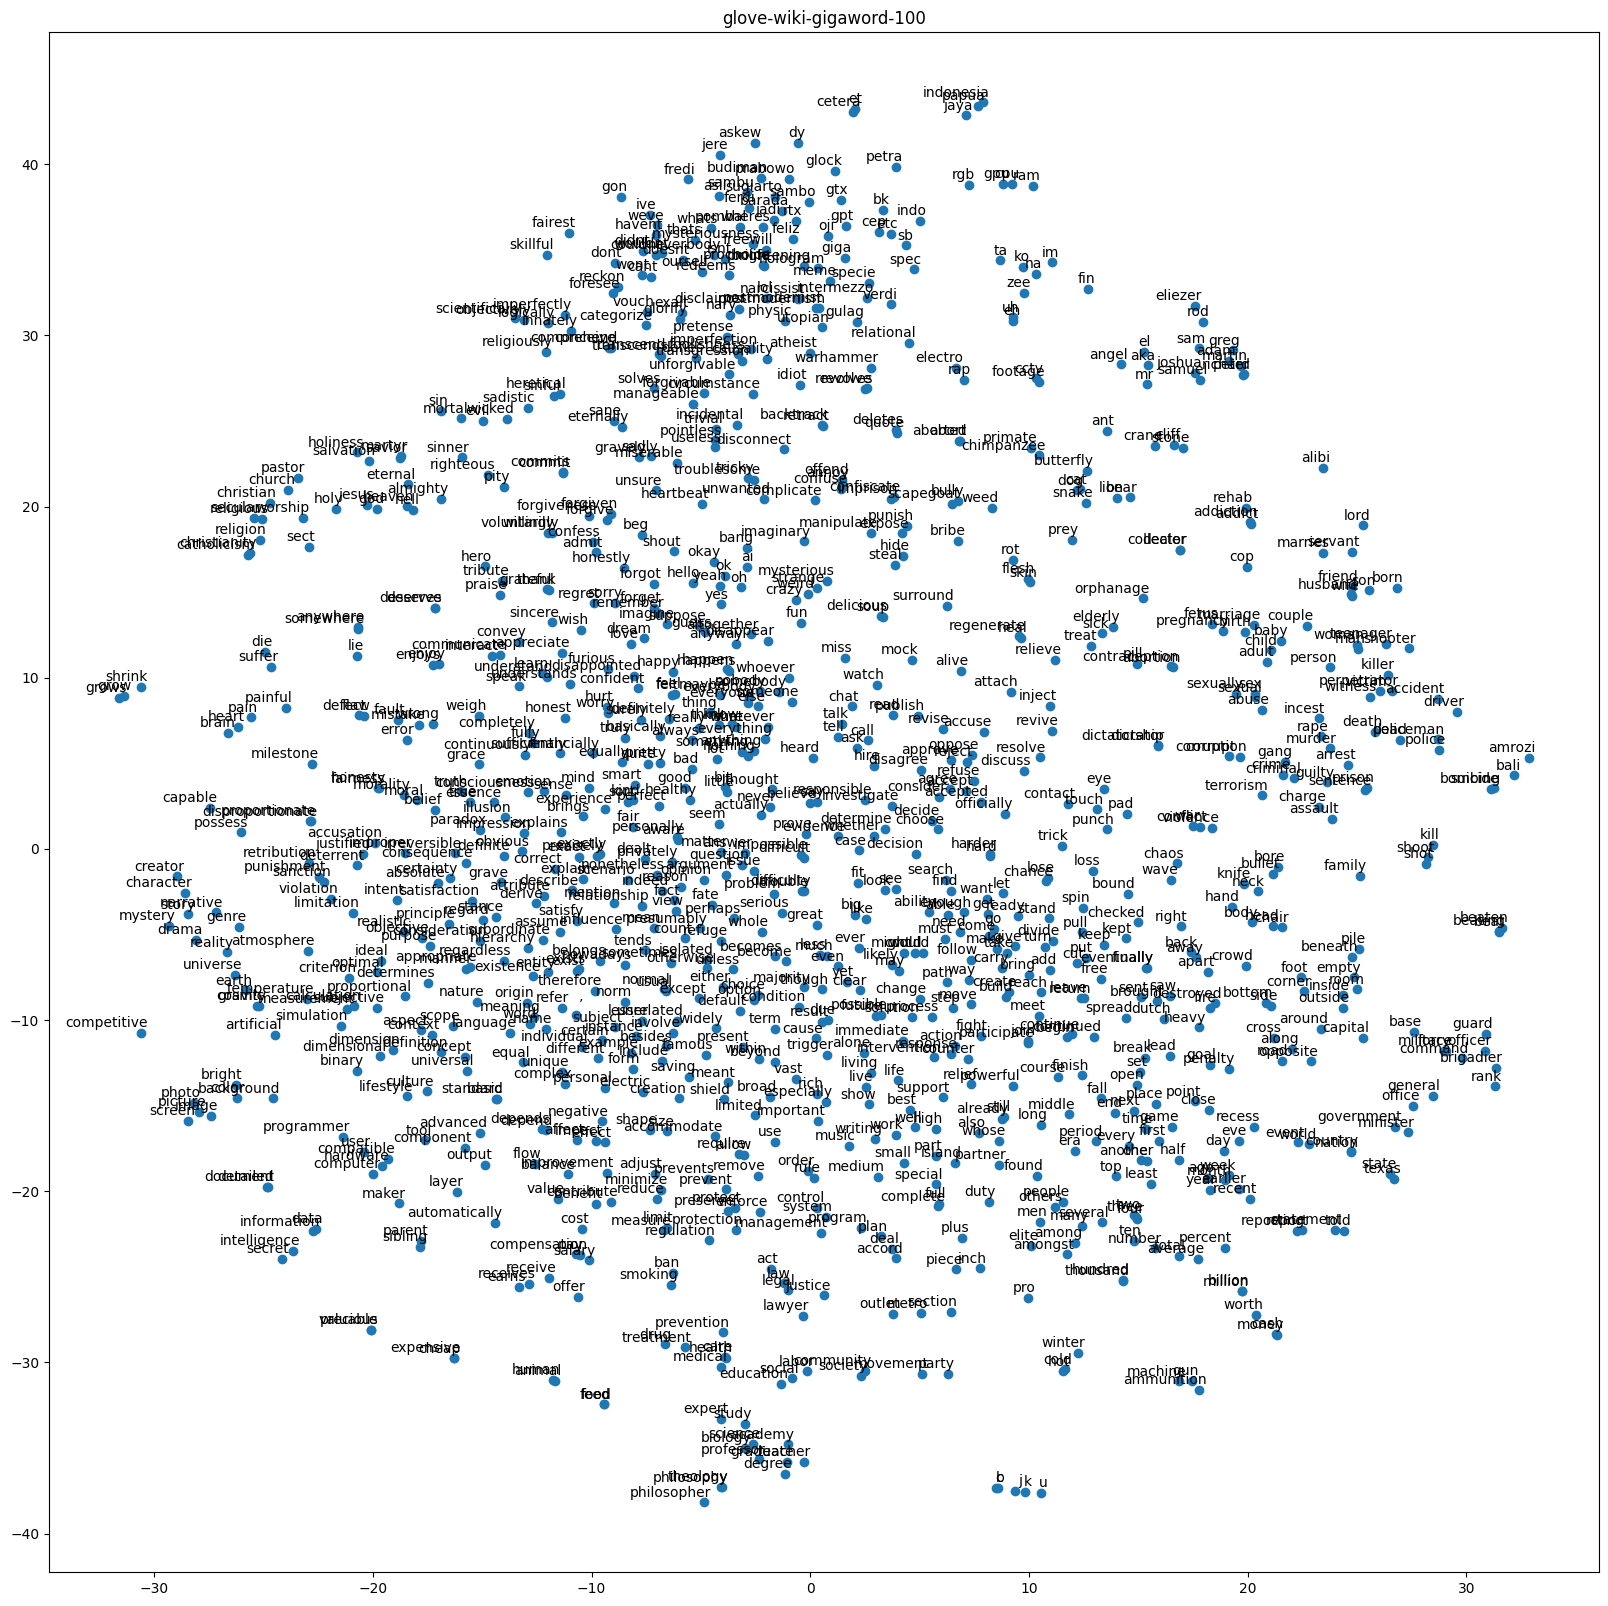

C:\Users\peter\AppData\Local\Temp\ipykernel_22744\1228325159.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], cmap="viridis")


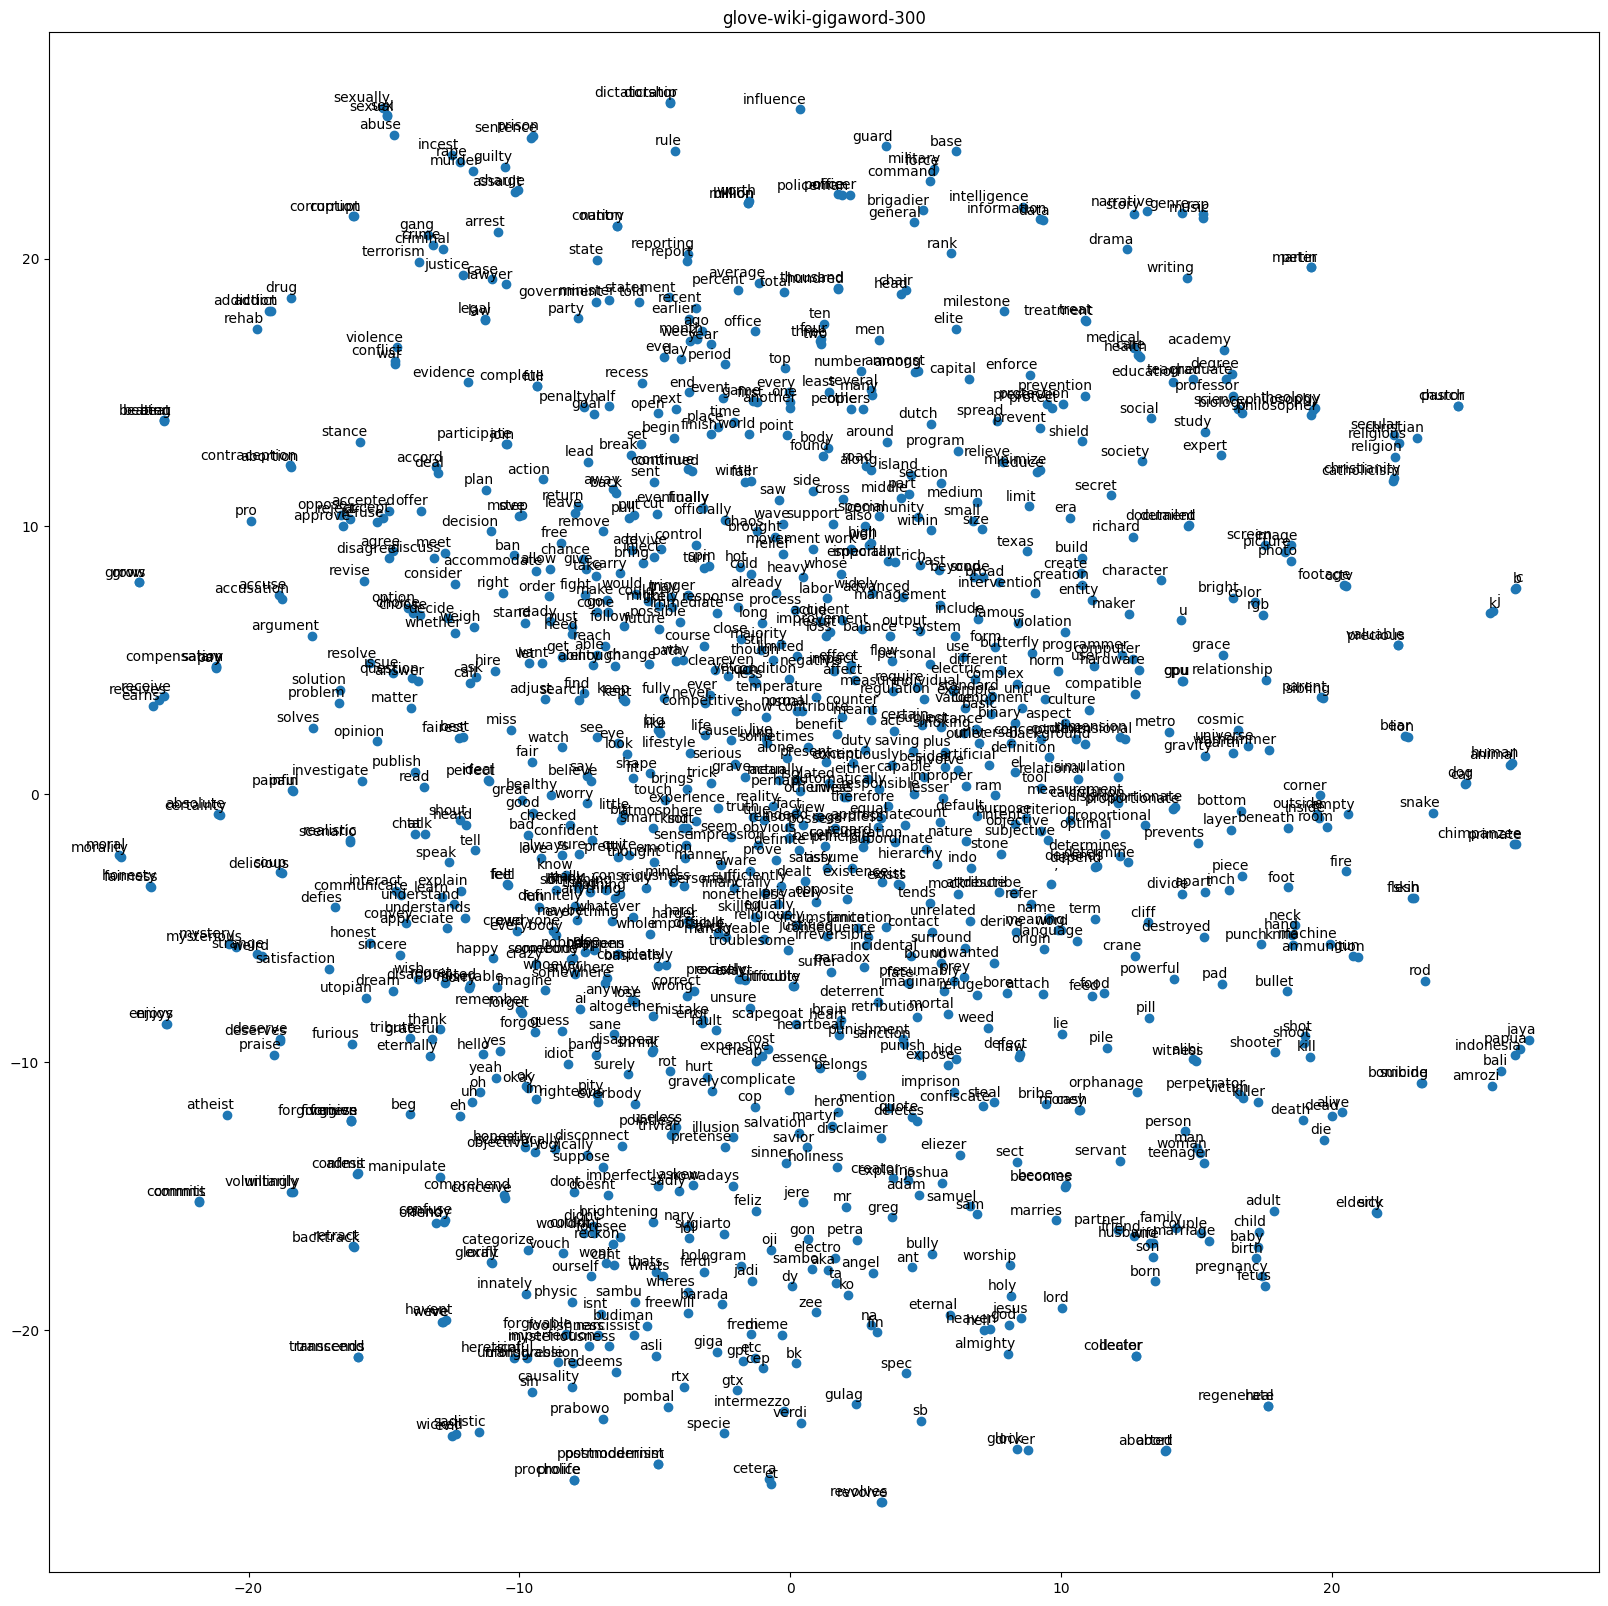

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

modelList = ["word2vec-google-news-300",
             "glove-wiki-gigaword-50",
             "glove-wiki-gigaword-100",
             "glove-wiki-gigaword-300"]

for model in modelList:

    WEModel = api.load(model)
    embedded_words = WordEmbed(mySet, WEModel)
    words, vectors = zip(*embedded_words)
    vectors = np.array(vectors)
    tsne = TSNE(n_components=2, random_state=69)
    reduced_vectors = tsne.fit_transform(vectors)

    plt.figure(figsize=(20,20))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], cmap="viridis")
    for i, word in enumerate(words):
        plt.annotate(word, 
                    xy=(reduced_vectors[i,0], reduced_vectors[i, 1]),
                    xytext=(5,2),
                    textcoords="offset points",
                    ha="right",
                    va="bottom"
                    )
    plt.title(model)
    plt.show()



In [9]:
# extra-class functions

def WriteInFile(df:pd.DataFrame, filePath:str="yakubian/ape.csv"):
    with open(file=filePath, mode="w") as file:
        file.write("question, answer\n")
        for i in range(len(df.index)):
            file.write("{},{}\n".format(df.loc[i]["id"], df.loc[i]["Cluster Assignment"]))


<h3>Parameter Combination

In [54]:
EventIDList = [18, 19, 20, 27, 28] # add later
def GetCombo(currentEventID:int):  
    FeatureExtractionList = ["LDA", "Embedding", "Tiny"]
    IsWeightedList = [True, False]
    AnomalyDetectionList = ["DBSCAN", "LOF", "IF"]
    LDATopicList = [5, 10, 20]
    WordEmbeddingModelList = ["word2vec-google-news-300",
                            "glove-wiki-gigaword-50",
                            "glove-wiki-gigaword-100",
                            "glove-wiki-gigaword-300"]
    epsilonRange = np.floor(np.arange(0.1, 2.1, 0.1) * 10)/10
    minsampRange = np.arange(2, 6)
    contaminationRange = np.floor(np.arange(0.1, 0.6, 0.1)*10)/10
    neighborRange = np.arange(2, 6)
    estimatorList = [50, 100, 500]

    combinations = []
    for WordEmbeddingModel in WordEmbeddingModelList:
        for FeatureExtraction in FeatureExtractionList:
            for IsWeighted in IsWeightedList:
                for AnomalyDetection in AnomalyDetectionList:
                    if AnomalyDetection == "DBSCAN":
                        for minsamp in minsampRange:
                            for epsilon in epsilonRange:
                                if FeatureExtraction == "LDA":
                                    for LDATopic in LDATopicList:
                                        combination = {
                                            "EventID" : currentEventID,
                                            "method" : FeatureExtraction,
                                            "weighted" : IsWeighted,
                                            "algorithm" : AnomalyDetection,
                                            "n_topics" : LDATopic,
                                            "epsilon" : epsilon,
                                            "minsamp" : minsamp
                                        }
                                        combinations.append(combination)
                                elif FeatureExtraction == "Embedding" or FeatureExtraction == "Tiny":
                                    combination = {
                                        "EventID" : currentEventID,
                                        "method" : FeatureExtraction,
                                        "weighted" : IsWeighted,
                                        "algorithm" : AnomalyDetection,
                                        "Model" : WordEmbeddingModel,
                                        "epsilon" : epsilon,
                                        "minsamp" : minsamp
                                    }
                                    combinations.append(combination)
                    elif AnomalyDetection == "LOF":
                        for contamination in contaminationRange:
                            for neighbor in neighborRange:
                                if FeatureExtraction == "LDA":
                                    for LDATopic in LDATopicList:
                                        combination = {
                                            "EventID" : currentEventID,
                                            "method" : FeatureExtraction,
                                            "weighted" : IsWeighted,
                                            "algorithm" : AnomalyDetection,
                                            "n_topics" : LDATopic,
                                            "contamination": contamination,
                                            "neighbors": neighbor
                                        }
                                        combinations.append(combination)
                                elif FeatureExtraction == "Embedding" or FeatureExtraction == "Tiny":
                                    combination = {
                                        "EventID" : currentEventID,
                                        "method" : FeatureExtraction,
                                        "weighted" : IsWeighted,
                                        "algorithm" : AnomalyDetection,
                                        "Model" : WordEmbeddingModel,
                                        "contamination": contamination,
                                        "neighbors": neighbor
                                    }
                                    combinations.append(combination)
                    elif AnomalyDetection == "IF":
                        for contamination in contaminationRange:
                            for estimator in estimatorList:
                                if FeatureExtraction == "LDA":
                                    for LDATopic in LDATopicList:
                                        combination = {
                                            "EventID" : currentEventID,
                                            "method" : FeatureExtraction,
                                            "weighted" : IsWeighted,
                                            "algorithm" : AnomalyDetection,
                                            "n_topics" : LDATopic,
                                            "contamination": contamination,
                                            "estimators": estimator
                                        }
                                        combinations.append(combination)
                                elif FeatureExtraction == "Embedding" or FeatureExtraction == "Tiny":
                                    combination = {
                                        "EventID" : currentEventID,
                                        "method" : FeatureExtraction,
                                        "weighted" : IsWeighted,
                                        "algorithm" : AnomalyDetection,
                                        "Model" : WordEmbeddingModel,
                                        "contamination": contamination,
                                        "estimators": estimator
                                    }
                                    combinations.append(combination)
    return combinations

<h3> Execution

In [57]:
def RunCombo(currentCombo): 
    currentEventID = 0
    currentModel = "word2vec-google-news-300"
    resultDict = {}
    for combo in currentCombo:
        # set eventID
        if combo["EventID"] != currentEventID:
            ad.SetDFFromDB(eventID=combo["EventID"])
            currentEventID = combo["EventID"]
        
        # set model
        if "Model" in combo and combo["Model"] != currentModel:
            print("current model : ", combo["Model"])
            ad.SetModel(combo["Model"])
            currentModel = combo["Model"]
            print("changed to : ", combo["Model"])
        
        # add keys
        for key in ad.AnomalyDetectionParams.keys():
            if key in combo:
                ad.AnomalyDetectionParams[key] = combo[key]
        for key in ad.FeatureExtractionParams.keys():
            if key in combo:
                ad.FeatureExtractionParams[key] = combo[key]

        # change model name
        if "Model" in combo:
            if combo["Model"] == "word2vec-google-news-300":
                modelShort = "n300"
            elif combo["Model"] == "glove-wiki-gigaword-50":
                modelShort = "g50"
            elif combo["Model"] == "glove-wiki-gigaword-100":
                modelShort = "g100"
            elif combo["Model"] == "glove-wiki-gigaword-300":
                modelShort = "g300"
        
        # change parameters
        if combo["algorithm"] == "DBSCAN":
            if combo["method"] == "LDA":
                filePath = f'{combo["EventID"]}_{ad.FeatureExtractionParams["method"]}_{ad.FeatureExtractionParams["n_topics"]}_{ad.FeatureExtractionParams["weighted"]}_{ad.AnomalyDetectionParams["algorithm"]}_{ad.AnomalyDetectionParams["epsilon"]}_{ad.AnomalyDetectionParams["minsamp"]}.csv'
            elif combo["method"] == "Embedding" or combo["method"] == "Tiny":
                filePath = f'{combo["EventID"]}_{ad.FeatureExtractionParams["method"]}_{modelShort}_{ad.FeatureExtractionParams["weighted"]}_{ad.AnomalyDetectionParams["algorithm"]}_{ad.AnomalyDetectionParams["epsilon"]}_{ad.AnomalyDetectionParams["minsamp"]}.csv'
        elif combo["algorithm"] == "LOF":
            if combo["method"] == "LDA":
                filePath = f'{combo["EventID"]}_{ad.FeatureExtractionParams["method"]}_{ad.FeatureExtractionParams["n_topics"]}_{ad.FeatureExtractionParams["weighted"]}_{ad.AnomalyDetectionParams["algorithm"]}_{ad.AnomalyDetectionParams["contamination"]}_{ad.AnomalyDetectionParams["neighbors"]}.csv'
            elif combo["method"] == "Embedding" or combo["method"] == "Tiny":
                filePath = f'{combo["EventID"]}_{ad.FeatureExtractionParams["method"]}_{modelShort}_{ad.FeatureExtractionParams["weighted"]}_{ad.AnomalyDetectionParams["algorithm"]}_{ad.AnomalyDetectionParams["contamination"]}_{ad.AnomalyDetectionParams["neighbors"]}.csv'
        elif combo["algorithm"] == "IF":
            if combo["method"] == "LDA":
                filePath = f'{combo["EventID"]}_{ad.FeatureExtractionParams["method"]}_{ad.FeatureExtractionParams["n_topics"]}_{ad.FeatureExtractionParams["weighted"]}_{ad.AnomalyDetectionParams["algorithm"]}_{ad.AnomalyDetectionParams["contamination"]}_{ad.AnomalyDetectionParams["estimators"]}.csv'
            elif combo["method"] == "Embedding" or combo["method"] == "Tiny":
                filePath = f'{combo["EventID"]}_{ad.FeatureExtractionParams["method"]}_{modelShort}_{ad.FeatureExtractionParams["weighted"]}_{ad.AnomalyDetectionParams["algorithm"]}_{ad.AnomalyDetectionParams["contamination"]}_{ad.AnomalyDetectionParams["estimators"]}.csv'

        print(combo["EventID"], " | ", filePath, " | current model : ", currentModel )
        result = ad.GetAnomalies()
        resultDict[filePath] = GetVerdict(combo["EventID"], result)
    return resultDict


In [73]:
combination18 = GetCombo(18)
combination19 = GetCombo(19)
combination20 = GetCombo(20)
combination27 = GetCombo(27)
combination28 = GetCombo(28)

In [58]:
combination18_result = RunCombo(combination18)

18  |  18_LDA_5_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_10_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_20_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_5_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_10_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_20_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_5_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_10_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_20_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_5_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_10_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-300
18  |  18_LDA_20_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-

In [80]:
combination27_result = RunCombo(combination27)

27  |  27_LDA_5_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_10_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_20_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_5_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_10_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_20_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_5_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_10_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_20_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_5_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_10_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-300
27  |  27_LDA_20_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-

In [81]:
with open("hasilsurvey/27result.csv", "w", newline="") as csvfile:
    csvfile.write("combination|similarity\n")
    for combo in combination27_result.keys():
        csvfile.write("{}|{}\n".format(combo, combination27_result[combo]))

In [64]:
print(len(combination18_result))

2530


In [82]:
combination28_result = RunCombo(combination28)

28  |  28_LDA_5_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_10_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_20_True_DBSCAN_0.1_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_5_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_10_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_20_True_DBSCAN_0.2_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_5_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_10_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_20_True_DBSCAN_0.3_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_5_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_10_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-300
28  |  28_LDA_20_True_DBSCAN_0.4_2.csv  | current model :  word2vec-google-news-

In [ ]:
with open("hasilsurvey/28result.csv", "w", newline="") as csvfile:
    csvfile.write("combination|similarity\n")
    for combo in combination28_result.keys():
        csvfile.write("{}|{}\n".format(combo, combination28_result[combo]))